# 全连接神经网络(Multi-Layer Perception,MLP)

## MLP分类模型

### 导入相关库

In [12]:
# 导入需要的库和相关模块
import numpy as np
import pandas as pd
# 数据标准化预处理
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# 数据集的切分
from sklearn.model_selection import train_test_split
# 评价模型的预测效果
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
# 数据降维及可视化
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
from torch.optim import SGD,Adam
import torch.utils.data as Data
import matplotlib.pyplot as plt
import seaborn as sns
# 模型可视化
# onnx==1.16.0
import netron
import hiddenlayer as hl
# from torchviz import make_dot

### 数据集

垃圾邮件分类。   
数据集: https://archive.ics.uci.edu/dataset/94/spambase    

57个邮件内容的特征统计:   
- 48个特征是关键词出现的频率x100的取值，范围为[0,100], 变量名使用word_freq_WORD命名
- 6个特征是关键字符出现的频率x100的取值，范围为[0,100]， 变量名使用char_freq_CHAR命名
- 1个变量为capital_run_length_average, 表示大写字母不间断的平均长度
- 1个变量为captial_run_length_longest, 表示大写字母不间断的最大长度
- 1个变量capital_run_length_total, 表示邮件中大写字母的数量

最后一个值为待预测目标变量(0,1),表示电子邮件被认为是垃圾邮件(1)或者不是(0)

### code

In [2]:
# 读取数据显示数据的前几行
spam = pd.read_csv("../data/spambase/spambase.data",header=None)
spam.head()
print(pd.value_counts(spam.iloc[:, -1]))

0    2788
1    1813
Name: 57, dtype: int64


In [21]:
# 将数据切分为训练集和测试集
x = spam.iloc[:,0:57].values
y = spam.iloc[:,-1].values
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=123)

In [22]:
# 对数据特征进行标准化处理
scales = MinMaxScaler(feature_range=(0,1))
x_train_s = scales.fit_transform(x_train)
x_test_s = scales.transform(x_test)

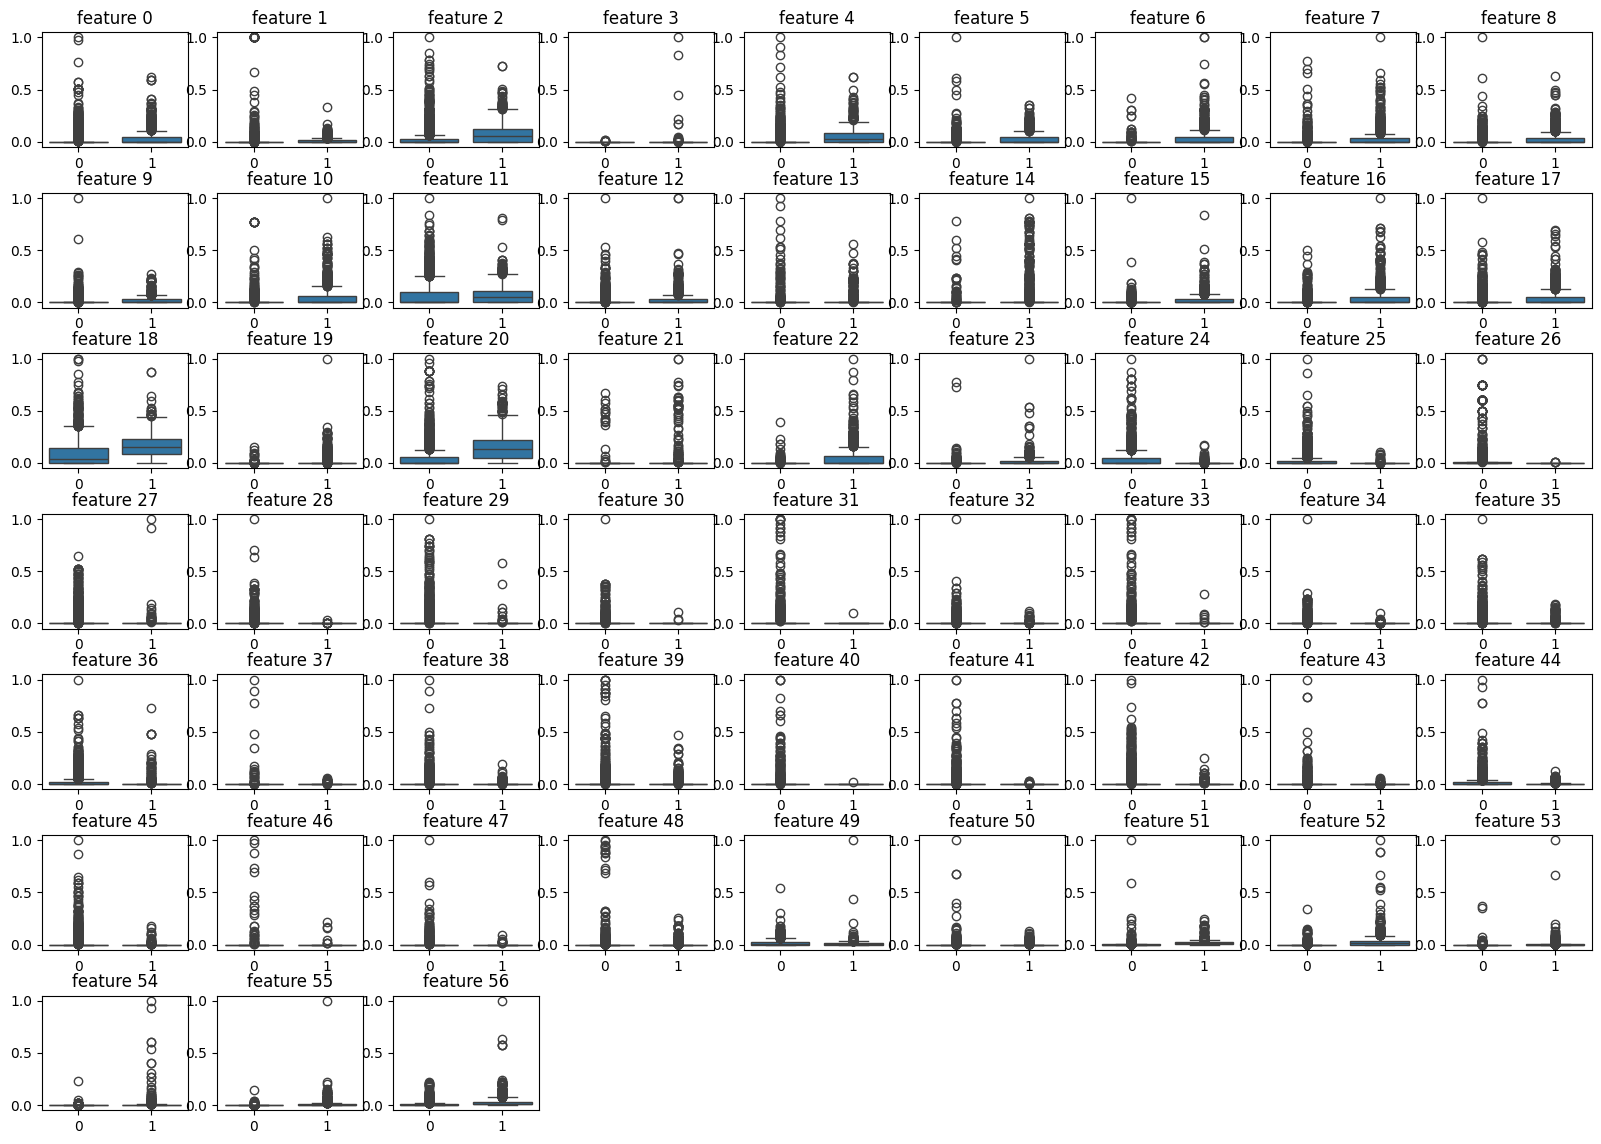

In [23]:
# 对比不同类型的邮件(垃圾邮件和非垃圾邮件)在每个特征变量上的数量分布情况。
plt.figure(figsize=(20,14))
for ii in range(57):
    plt.subplot(7,9,ii+1)
    sns.boxplot(x=y_train,y=x_train_s[:,ii])
    plt.title("feature %d"%(ii))
plt.subplots_adjust(hspace=0.4)
plt.show()

In [24]:
# 全连接网络
class MLPclassifica(nn.Module):
    def __init__(self):
        super(MLPclassifica,self).__init__()
        # 定义第一个隐藏层
        self.hidden1 = nn.Sequential(
            nn.Linear(
                in_features = 57 , # 数据的特征数
                out_features= 30 , # 神经元的数量
                bias = True ,      # 默认会有偏置
            ),
            nn.ReLU()
        )
        
        # 定义第二个隐藏层
        self.hidden2 = nn.Sequential(
            nn.Linear(30,10),
            nn.ReLU()
        )
        
        # 分类层
        self.classifica = nn.Sequential(
            nn.Linear(10,2),
            nn.Sigmoid()
        )
        
    # 定义网络的前向传播路径
    def forward(self,x):
        fc1 = self.hidden1(x)
        fc2 = self.hidden2(fc1)
        output = self.classifica(fc2)
        # 输出为两个隐藏层和输出层
        return fc1,fc2,output

In [25]:
# 创建模型实例
model = MLPclassifica()
# 设置输入
inputdata = torch.randn(1, 57)
# 将模型导出为 ONNX 格式
torch.onnx.export(model, inputdata, '../model/mlpclassifica_model.onnx')  

查看模型可视化: https://netron.app/

In [26]:
x_train_t = torch.from_numpy(x_train_s.astype(np.float32))
y_train_t = torch.from_numpy(y_train.astype(np.int64))
x_test_t = torch.from_numpy(x_test_s.astype(np.float32))
y_test_t = torch.from_numpy(y_test.astype(np.int64))
# 将训练集转换为张量后，使用TensorDataset将x和y整合到一起
train_data = Data.TensorDataset(x_train_t,y_train_t)
# 定义一个数据加载器，将训练集进行批量处理
train_loader = Data.DataLoader(
    dataset = train_data , # 使用的数据集
    batch_size = 64 , # 批处理样本大小
    shuffle = True  , # 每次迭代前打乱数据
    num_workers = 1 
)

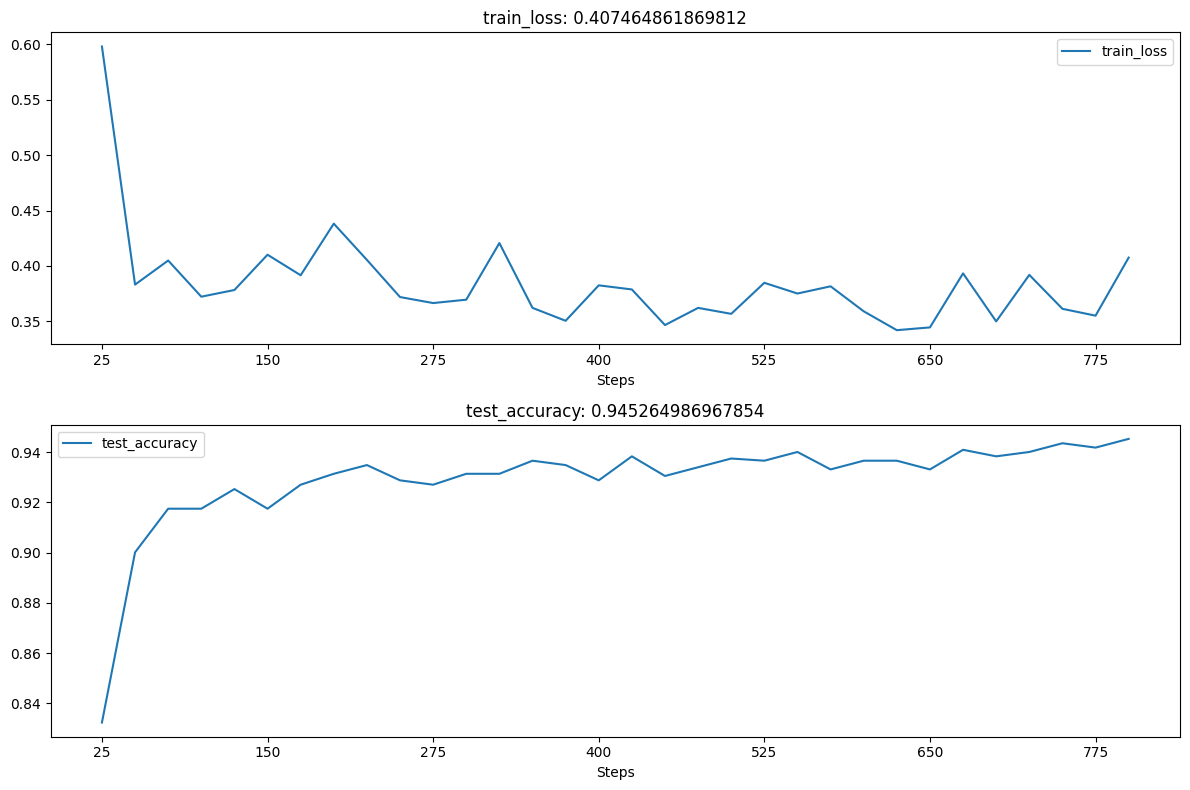

In [27]:
# 定义优化器
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
loss_func = nn.CrossEntropyLoss() # 交叉熵损失函数
# 记录训练过程的指标
history1 = hl.History()
# 使用Canvas进行可视化
canvas1 = hl.Canvas()
print_step = 25
# 对模型进行迭代训练
for epoch in range(15):
    # 对训练数据的加载器进行迭代计算
    for step,(b_x,b_y) in enumerate( train_loader):
        # 计算每个batch的损失
        _,_,output = model(b_x) # mlp在训练batch上的输出
        train_loss = loss_func(output,b_y) # 交叉熵损失函数
        optimizer.zero_grad() # 每个迭代的梯度初始化为0
        train_loss.backward() # 损失的后向传播，计算梯度
        optimizer.step()      # 使用梯度进行优化
        niter = epoch * len(train_loader) + step + 1
        # 计算每经过print_step次迭代后的输出
        if niter % print_step == 0:
            _,_,output = model(x_test_t)
            _,pre_lab = torch.max(output,1)
            test_accuracy = accuracy_score(y_test_t,pre_lab)
            # 为history 添加 epoch,损失和精度
            history1.log(niter,train_loss=train_loss,test_accuracy=test_accuracy)
            # 使用俩个图像可视化损失函数和精度
            with canvas1:
                canvas1.draw_plot(history1["train_loss"])
                canvas1.draw_plot(history1["test_accuracy"])

In [28]:
# 在测试集上的最终精度
_,_,output = model(x_test_t)
_,pre_lab = torch.max(output,1)
test_accuracy = accuracy_score(y_test_t,pre_lab)
print("test_accuracy:",test_accuracy)

test_accuracy: 0.945264986967854


test_accuracy: 0.945264986967854

## MLP回归模型

### 导入相关库

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
# 导入数据集
from sklearn.datasets import fetch_california_housing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
import torch.utils.data as Data
import matplotlib.pyplot as plt
import seaborn as sns

### 数据集

使用california房屋价格数据。     
该数据集源自1990年美国人口普查，每行样本是每个人普查区块组的描述数据，区块组通常拥有600~3000的人口。    
在数据集中一共包含20640个样本，数据有8个自变量，如收入平均数、房屋年龄，平均房间数量等。    
因变量为房屋在该区块组的价格中位数。     
- MedInc：区域内家庭收入的中位数（单位：10,000美元）。
- HouseAge：房屋的中位数年龄（单位：年）。
- AveRooms：每个住宅单元的平均房间数。
- AveBedrms：每个住宅单元的平均卧室数。
- Population：区域内的总人口数量。
- AveOccup：每个住宅单元的平均住户人数。
- Latitude：区域的纬度（地理坐标）。
- Longitude：区域的经度（地理坐标）。

MedHouseVal：目标变量，区域内房价的中位数（单位：10,000美元)

### code

In [12]:
# 导入数据
housdata = fetch_california_housing()
# 数据切分为训练集和测试集
x_train, x_test,y_train,y_test = train_test_split(
    housdata.data,housdata.target,test_size=0.3,random_state=42
)
# 数据标准化处理
scale = StandardScaler()
x_train_s = scale.fit_transform(x_train)
x_test_s = scale.transform(x_test)
# 将训练集数据处理为数据表
housdatadf = pd.DataFrame(data=x_train_s,columns=housdata.feature_names)
housdatadf["target"] = y_train

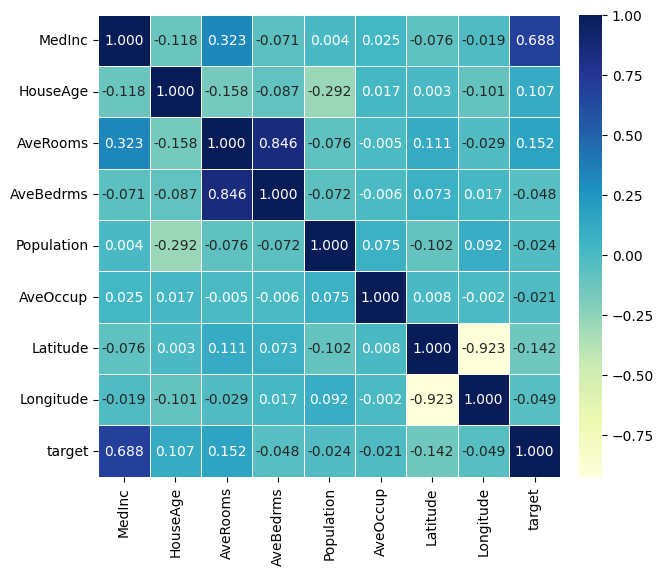

In [13]:
# 可视化数据的相关系数热力图
datacor = np.corrcoef(housdatadf.values,rowvar=0)
datacor = pd.DataFrame(data=datacor,columns=housdatadf.columns,index=housdatadf.columns)
plt.figure(figsize=(8,6))
ax = sns.heatmap(datacor,square=True,annot=True,fmt=".3f",linewidths=0.5,cmap="YlGnBu",
    cbar_kws={"fraction":0.046,"pad":0.03})
plt.show()

In [14]:
# 将数据集转换为张量
train_xt = torch.from_numpy(x_train_s.astype(np.float32))
train_yt = torch.from_numpy(y_train.astype(np.float32))
test_xt = torch.from_numpy(x_test_s.astype(np.float32))
test_yt = torch.from_numpy(y_test.astype(np.float32))
# 将训练数据处理为数据加载器
train_data = Data.TensorDataset(train_xt,train_yt)
train_loader = Data.DataLoader(dataset = train_data,batch_size=64,shuffle=True,num_workers=1)

In [15]:
# 搭建全连接神经网络回归网络
class MLPregression(nn.Module):
    def __init__(self):
        super(MLPregression,self).__init__()
        # 定义第一个隐藏层
        self.hidden1 = nn.Linear(in_features = 8, out_features = 100,bias = True)
        # 定义第二个隐藏层
        self.hidden2 = nn.Linear(100,100)
        # 定义第三个隐藏层
        self.hidden3 = nn.Linear(100,50)
        # 回归预测
        self.predict = nn.Linear(50,1)
    # 定义网络的向前传播路径
    def forward(self,x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        output = self.predict(x)
        # 输出一个一维向量
        return output[:,0]
        
# 输出网络结构
model = MLPregression()
print(model)

MLPregression(
  (hidden1): Linear(in_features=8, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (hidden3): Linear(in_features=100, out_features=50, bias=True)
  (predict): Linear(in_features=50, out_features=1, bias=True)
)


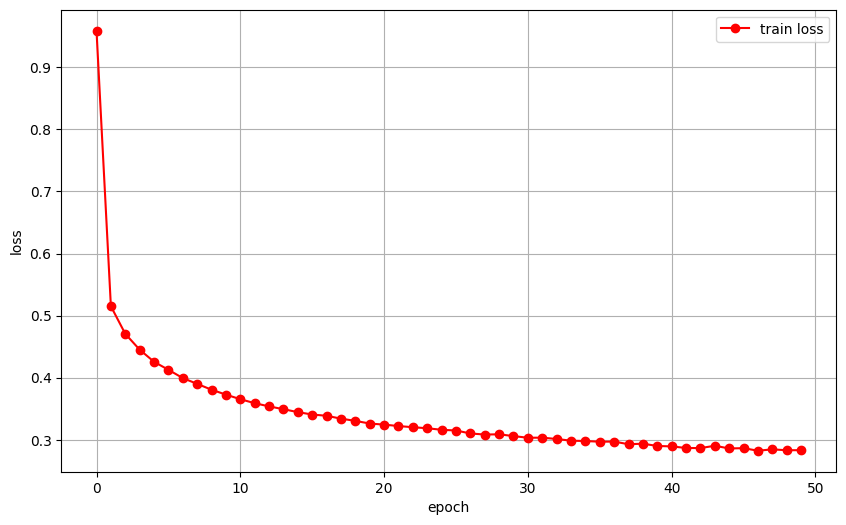

In [16]:
# 定义优化器
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
loss_func = nn.MSELoss() # 均方根误差损失函数
train_loss_all = []
# 对模型进行迭代训练，对所有的数据训练epoch轮
for epoch in range(50):
    train_loss = 0
    train_num = 0
    # 对训练数据的加载器进行迭代计算
    for step,(b_x,b_y) in enumerate(train_loader):
        output = model(b_x)          # MLP在训练batch上的输出
        loss = loss_func(output,b_y) # 均方根误差损失函数
        optimizer.zero_grad()        # 每个迭代步的梯度初始化为0
        loss.backward()              # 损失的后向传播，计算梯度
        optimizer.step()             # 使用梯度进行优化
        train_loss += loss.item() * b_x.size(0)
        train_num += b_x.size(0)
    train_loss_all.append(train_loss / train_num)
# 可视化损失函数的变化情况
plt.figure(figsize=(10,6))
plt.plot(train_loss_all,"ro-",label="train loss")
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [10]:
# 对测试集进行预测
pre_y = model(test_xt)
pre_y = pre_y.data.numpy()
mae = mean_absolute_error(y_test,pre_y)
print("在测试集上的绝对值误差为:",mae)

在测试集上的绝对值误差为: 0.37998106974828766


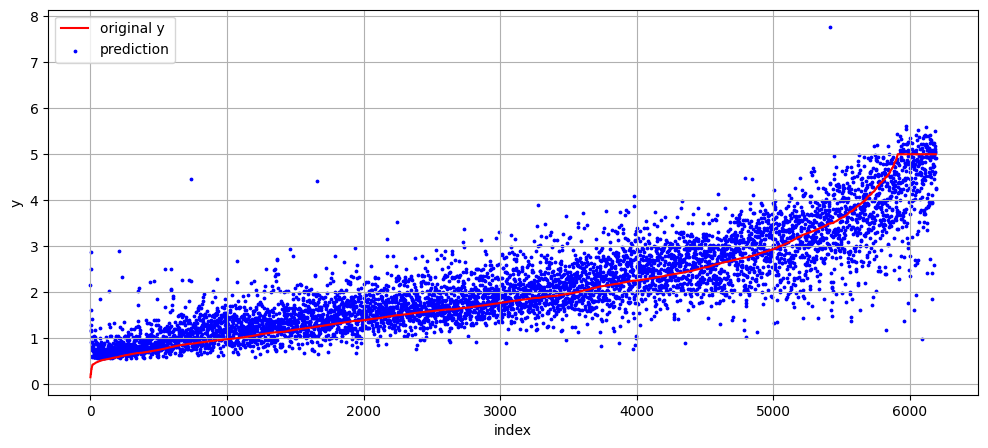

In [17]:
# 可视化在测试集上真实值和预测值的差异
index = np.argsort(y_test)
plt.figure(figsize=(12,5))
plt.plot(np.arange(len(y_test)),y_test[index],"r",label="original y")
plt.scatter(np.arange(len(pre_y)),pre_y[index],s=3,c='b',label="prediction")
plt.legend(loc="upper left")
plt.grid()
plt.xlabel("index")
plt.ylabel("y")
plt.show()